In [1]:
import torch
import torchvision
from glob import glob
import torch.nn as nn
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch.nn.functional as F
import torchvision.transforms as transform
from torch.utils.data import DataLoader, Dataset
from torch.utils.tensorboard import SummaryWriter
from torchvision.utils import make_grid
import torch
import torchvision.models as models
import torchvision.transforms as transforms
import numpy as np  # linear algebra
import pandas as pd  # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os

In [2]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
train_path = glob("./cityscapes_data/train/*")
valid_path = glob("./cityscapes_data/val/*")

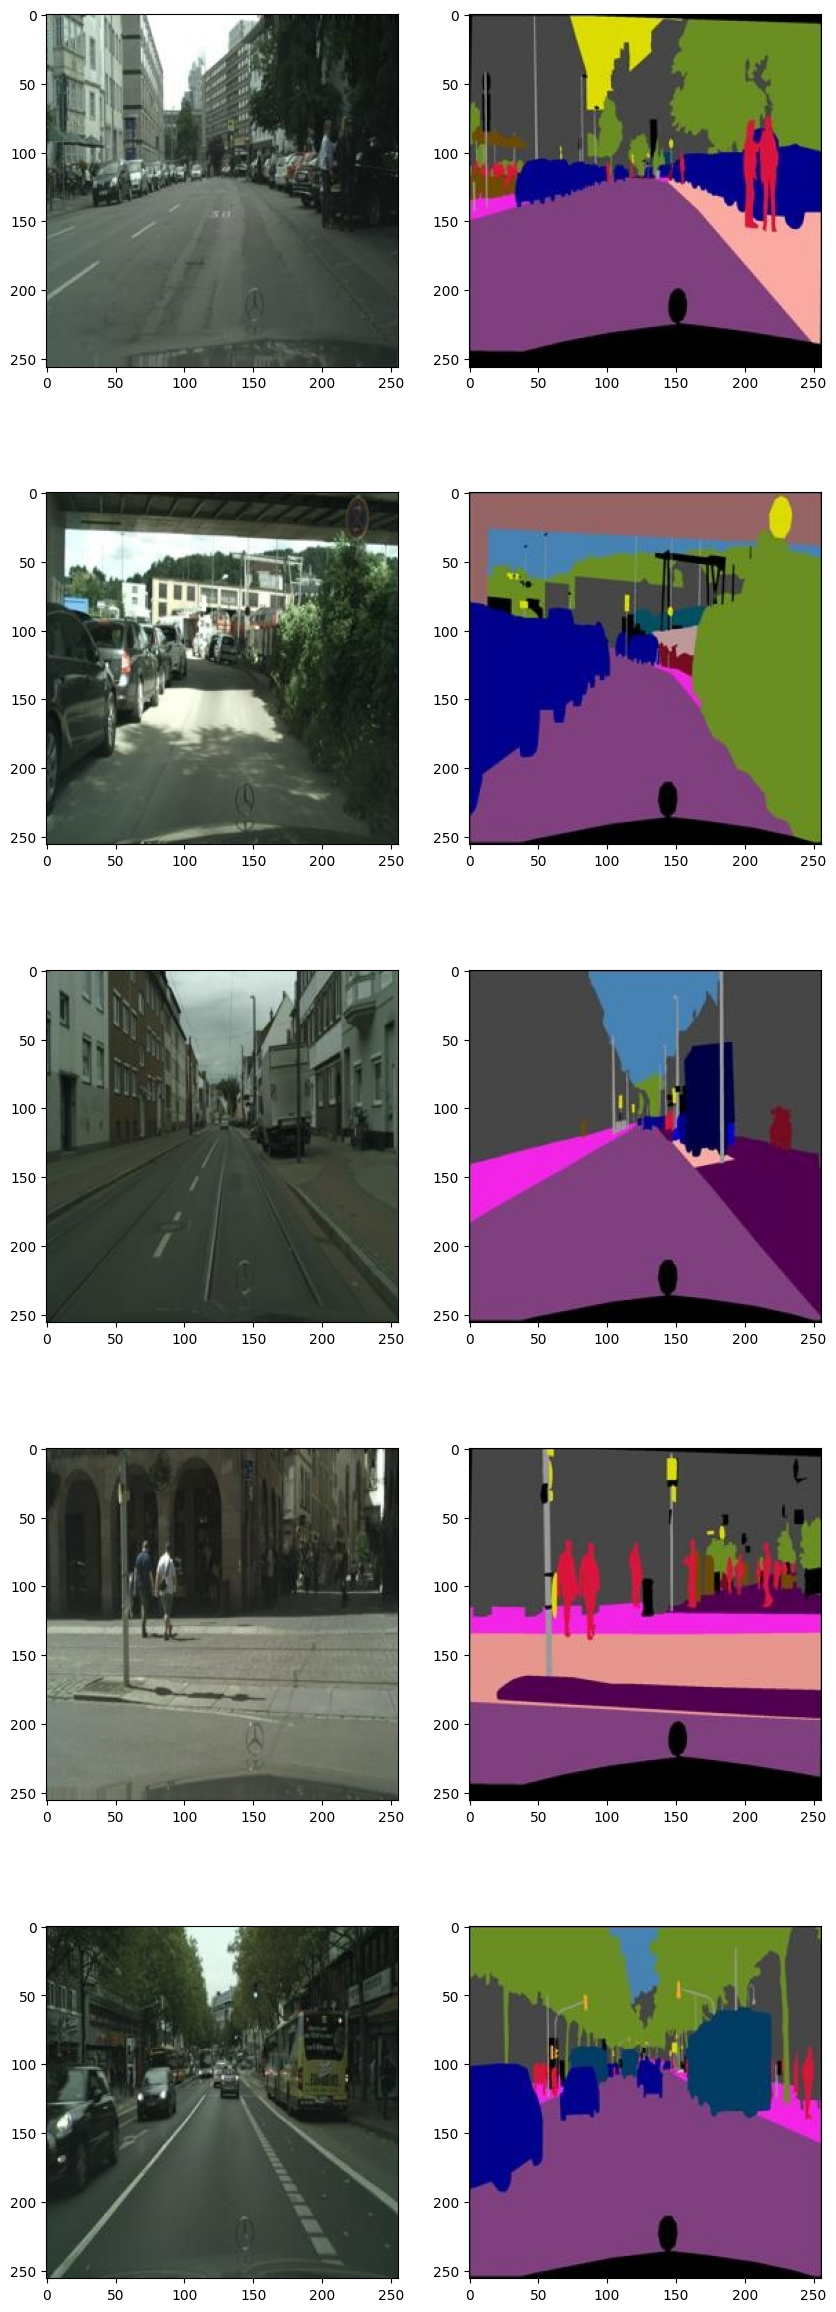

In [4]:
fig, ax = plt.subplots(5, 2, figsize=(10, 30))
for i in range(5):
    img = plt.imread(train_path[i])
    ax[i][0].imshow(img[:, :256])
    ax[i][1].imshow(img[:, 256:])

In [5]:
from PIL import Image


class MyDataset(Dataset):
    def __init__(self, images_path, transform_img=None, transform_label=None):
        self.images_path = images_path
        self.transform_img = transform.Compose([transform.ToTensor(), transform_img])
        self.transform_label = transform_label

    def __len__(self):
        return len(self.images_path)

    def __getitem__(self, idx):
        img = plt.imread(self.images_path[idx])
        image, label = img[:, :256], img[:, 256:]

        # Convert image and label from NumPy arrays to PIL Images
        image = Image.fromarray(image)
        label = Image.fromarray(label)

        if self.transform_img:
            image = self.transform_img(image)
        if self.transform_label:
            label = self.transform_label(label)

        return image, label

In [6]:


# Load the pre-trained VGG19 model
vgg19 = models.vgg19(pretrained=True)
vgg19 = vgg19.to(device)



traindata = MyDataset(train_path)
valdata = MyDataset(valid_path)

train_loader = torch.utils.data.DataLoader(traindata, batch_size=32, shuffle=True)
val_loader = torch.utils.data.DataLoader(valdata, batch_size=32, shuffle=False)

/home/voy/.conda/envs/chinaa312/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/voy/.conda/envs/chinaa312/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG19_Weights.IMAGENET1K_V1`. You can also use `weights=VGG19_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [7]:
train_image_paths ="/home/voy/space/cud/chinaagood/cityscapes_data/train"
val_image_paths = "/home/voy/space/cud/chinaagood/cityscapes_data/val"

In [8]:
train_dir = "/home/voy/space/cud/chinaagood/cityscapes_data/train"

# Get the list of image file paths
train_image_paths = []
for filename in os.listdir(train_dir):
    if filename.endswith(".jpg") or filename.endswith(
        ".png"
    ):  # Adjust the file extensions as per your dataset
        file_path = os.path.join(train_dir, filename)
        train_image_paths.append(file_path)

In [9]:
class SplitImageDataset(Dataset):
    def __init__(self, image_paths, transform=None):
        self.image_paths = image_paths
        self.transform = transform

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image = Image.open(image_path).convert("RGB")
        width, height = image.size

        left_half = image.crop((0, 0, width // 2, height))
        right_half = image.crop((width // 2, 0, width, height))

        if self.transform:
            left_half = self.transform(left_half)
            right_half = self.transform(right_half)

        return left_half, right_half

In [10]:
transform = transforms.Compose(
    [
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [11]:
train_dataset = SplitImageDataset(train_image_paths, transform=transform)
val_dataset = SplitImageDataset(val_image_paths, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

In [12]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms


class Convblock(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, 3, 1, 1),
            nn.LeakyReLU(0.01),
            nn.Dropout(0.1),
            nn.Conv2d(out_channels, out_channels, 3, 1, 1),
            nn.LeakyReLU(0.01),
        )

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, input_channel, retain=True):
        super().__init__()
        self.conv1 = Convblock(input_channel, 32)
        self.conv2 = Convblock(32, 64)
        self.conv3 = Convblock(64, 128)
        self.conv4 = Convblock(128, 256)
        self.neck = nn.Conv2d(256, 512, 3, 1, 1)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1)
        self.dconv4 = Convblock(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.dconv3 = Convblock(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.dconv2 = Convblock(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.dconv1 = Convblock(64, 32)
        self.out = nn.Conv2d(32, 3, 1, 1)
        self.retain = retain

    def forward(self, x):
        # Encoder Network
        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1, kernel_size=2, stride=2)

        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2, kernel_size=2, stride=2)

        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3, kernel_size=2, stride=2)

        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4, kernel_size=2, stride=2)

        # Bottleneck
        neck = self.neck(pool4)

        # Decoder Network
        # Upconv 1
        upconv4 = self.upconv4(neck)
        cropped = self.crop(conv4, upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4, cropped], 1))

        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        cropped = self.crop(conv3, upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3, cropped], 1))

        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        cropped = self.crop(conv2, upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2, cropped], 1))

        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        cropped = self.crop(conv1, upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1, cropped], 1))

        # Output Layer
        out = self.out(dconv1)
        if self.retain:
            out = F.interpolate(out, list(x.shape)[2:])

        return out

    def crop(self, input_tensor, target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _, _, H, W = target_tensor.shape
        return transforms.CenterCrop([H, W])(input_tensor)

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms, models


class AttentionGate(nn.Module):
    def __init__(self, in_channels, gating_channels):
        super(AttentionGate, self).__init__()
        self.conv = nn.Conv2d(in_channels, gating_channels, kernel_size=1)
        self.gating = nn.Conv2d(gating_channels, in_channels, kernel_size=1)

    def forward(self, x, g):
        x_conv = self.conv(x)
        g_conv = self.conv(g)
        add = x_conv + g_conv
        act = torch.sigmoid(add)
        out = x * act
        return out


class UNet(nn.Module):
    def __init__(self, input_channel, retain=True):
        super().__init__()
        self.conv1 = Convblock(input_channel, 32)
        self.conv2 = Convblock(32, 64)
        self.conv3 = Convblock(64, 128)
        self.conv4 = Convblock(128, 256)
        self.neck = nn.Conv2d(256, 512, 3, 1, 1)
        self.upconv4 = nn.ConvTranspose2d(512, 256, 3, 2, 1, 1)
        self.dconv4 = Convblock(512, 256)
        self.upconv3 = nn.ConvTranspose2d(256, 128, 3, 2, 1, 1)
        self.dconv3 = Convblock(256, 128)
        self.upconv2 = nn.ConvTranspose2d(128, 64, 3, 2, 1, 1)
        self.dconv2 = Convblock(128, 64)
        self.upconv1 = nn.ConvTranspose2d(64, 32, 3, 2, 1, 1)
        self.dconv1 = Convblock(64, 32)
        self.out = nn.Conv2d(32, 3, 1, 1)
        self.retain = retain

        # Load pre-trained VGG19 model
        vgg19 = models.vgg19(pretrained=True)
        self.vgg_features = vgg19.features[:28]  # Extract features from VGG19

        # Attention gate
        self.attention_gate = AttentionGate(512, 512)

    def forward(self, x):
        # Encoder Network
        # Conv down 1
        conv1 = self.conv1(x)
        pool1 = F.max_pool2d(conv1, kernel_size=2, stride=2)
        # Conv down 2
        conv2 = self.conv2(pool1)
        pool2 = F.max_pool2d(conv2, kernel_size=2, stride=2)
        # Conv down 3
        conv3 = self.conv3(pool2)
        pool3 = F.max_pool2d(conv3, kernel_size=2, stride=2)
        # Conv down 4
        conv4 = self.conv4(pool3)
        pool4 = F.max_pool2d(conv4, kernel_size=2, stride=2)

        # Bottleneck
        neck = self.neck(pool4)

        # Extract features from VGG19
        with torch.no_grad():
            vgg_features = self.vgg_features(x)

        # Apply attention gate
        gated_features = self.attention_gate(neck, vgg_features)

        # Decoder Network
        # Upconv 1
        upconv4 = self.upconv4(gated_features)
        cropped = self.crop(conv4, upconv4)
        # Making the skip connection 1
        dconv4 = self.dconv4(torch.cat([upconv4, cropped], 1))
        # Upconv 2
        upconv3 = self.upconv3(dconv4)
        cropped = self.crop(conv3, upconv3)
        # Making the skip connection 2
        dconv3 = self.dconv3(torch.cat([upconv3, cropped], 1))
        # Upconv 3
        upconv2 = self.upconv2(dconv3)
        cropped = self.crop(conv2, upconv2)
        # Making the skip connection 3
        dconv2 = self.dconv2(torch.cat([upconv2, cropped], 1))
        # Upconv 4
        upconv1 = self.upconv1(dconv2)
        cropped = self.crop(conv1, upconv1)
        # Making the skip connection 4
        dconv1 = self.dconv1(torch.cat([upconv1, cropped], 1))

        # Output Layer
        out = self.out(dconv1)
        if self.retain:
            out = F.interpolate(out, list(x.shape)[2:])
        return out

    def crop(self, input_tensor, target_tensor):
        # For making the size of the encoder conv layer and the decoder Conv layer same
        _, _, H, W = target_tensor.shape
        return transforms.CenterCrop([H, W])(input_tensor)

In [14]:
print("Training image paths:")
for path in train_image_paths:
    print(path)

Training image paths:
/home/voy/space/cud/chinaagood/cityscapes_data/train/1468.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2650.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/515.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2033.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/13.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/1487.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/170.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/1754.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/1570.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/937.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2591.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2099.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2965.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/118.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2577.jpg
/home/voy/space/cud/chinaagood/cityscapes_data/train/2

In [15]:
train_image_paths

['/home/voy/space/cud/chinaagood/cityscapes_data/train/1468.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/2650.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/515.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/2033.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/13.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/1487.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/170.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/1754.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/1570.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/937.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/2591.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/2099.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/2965.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/118.jpg',
 '/home/voy/space/cud/chinaagood/cityscapes_data/train/2577.jpg',
 '/home/voy/spac

In [16]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define data transforms
transform = transforms.Compose(
    [
        transforms.Resize((256, 256)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

# Create dataset and data loader
train_dataset = SplitImageDataset(train_image_paths, transform=transform)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)

# Create UNet model
model = UNet(input_channel=3).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 50
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for batch_idx, (images, masks) in enumerate(train_loader):
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")

print("Training finished!")

OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU 0 has a total capacity of 3.81 GiB of which 63.19 MiB is free. Process 14070 has 1.15 GiB memory in use. Including non-PyTorch memory, this process has 2.57 GiB memory in use. Of the allocated memory 2.46 GiB is allocated by PyTorch, and 38.89 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)